## Using Eleanor API to Identify resolve our Saturated Targets

The aim is to read in TIC ID's of the saturated targets (which are also likely 2-min target candidates) and download + compute the contents of `single_analysis_xrp.py` onto it, as the lightcurves from the Bucket use Eleanor's default apertures. This is fine for the most part, but as we have found out that Beta Pic's exocomets cannot be seen with these default apertures, we use an arbitrarily large aperture to expand the search instead.

In [1]:
import eleanor
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
print(eleanor.__path__)

['/Users/azib/opt/anaconda3/envs/auto_exo/lib/python3.7/site-packages/eleanor']


Standard aperture selected when bringing in lightcurve:

## Functions

In [3]:
def normalise_lc(flux):
    return flux/flux.mean()

## Eleanor lightcurves with default apertures

In [4]:
star = eleanor.Source(tic=270577175,sector=5) # beta pic
star_data = eleanor.TargetData(star, height=13, width=13, bkg_size=31, do_pca=True)

INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-3-4-cal-0706-0538_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-3-4-cal-0706-0538_tess_v2_bkg.fits with expected size 73658880. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-3-4-cal-0706-0538_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-3-4-cal-0706-0538_tess_v2_pc.fits with expected size 147421440. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-3-4-cal-0706-0538_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-3-4_tess_v2_pm.txt with expected size 223078. [astroquery.query]


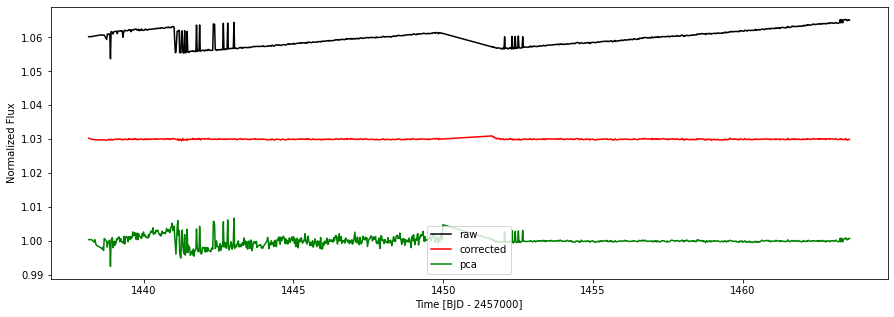

In [5]:
q = star_data.quality == 0
plt.figure(figsize=(15,5))


plt.plot(star_data.time[q], star_data.raw_flux[q]/np.nanmedian(star_data.raw_flux[q])+0.06, 'k',label='raw')
plt.plot(star_data.time[q], star_data.corr_flux[q]/np.nanmedian(star_data.corr_flux[q]) + 0.03, 'r',label='corrected')
plt.plot(star_data.time[q], star_data.pca_flux[q]/np.nanmedian(star_data.pca_flux[q]), 'g',label='pca')
#plt.plot(star_data.time[q], star_data.psf_flux[q]/np.nanmedian(star_data.psf_flux[q]) - 0.02, 'b',label='psf')
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.legend();

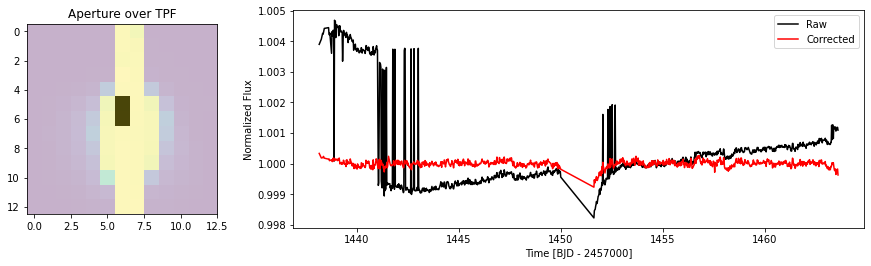

In [6]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax.imshow(star_data.tpf[0])
ax.imshow(star_data.all_apertures[0], cmap='Greys', alpha=0.7)
ax.set_title('Aperture over TPF')

ax1.plot(star_data.time[q], star_data.all_raw_flux[0][q]/np.nanmedian(star_data.all_raw_flux[0][q]), 'k', label='Raw')
ax1.plot(star_data.time[q], star_data.all_corr_flux[0][q]/np.nanmedian(star_data.all_corr_flux[0][q]), 'r', label='Corrected')
ax1.set_xlabel('Time [BJD - 2457000]')
ax1.set_ylabel('Normalized Flux')
ax1.legend();

### The chosen `Eleanor` aperture

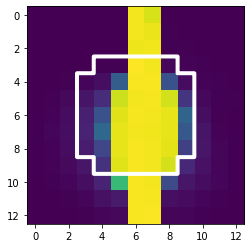

In [7]:
vis = eleanor.Visualize(star_data)
vis.aperture_contour()

## Custom Aperture

Text(0, 0.5, 'Normalized Flux')

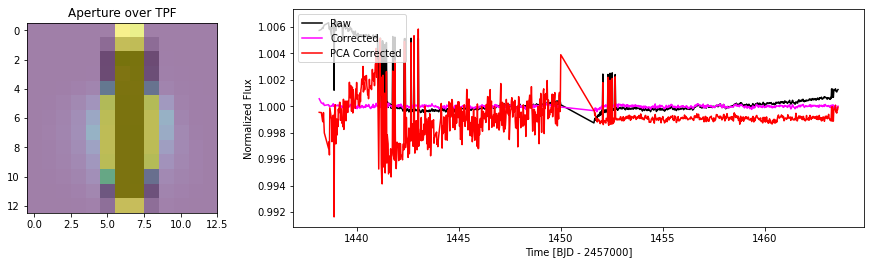

In [8]:
eleanor.TargetData.custom_aperture(star_data, shape='rectangle', h=11, w=3)
eleanor.TargetData.get_lightcurve(star_data)

fig, (ax2, ax3) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax2.imshow(star_data.tpf[0])
ax2.imshow(star_data.aperture, cmap='Greys', alpha=0.5)
ax2.set_title('Aperture over TPF')
#plt.imshow(data.aperture)

ax3.plot(star_data.time[q], star_data.raw_flux[q]/np.nanmedian(star_data.raw_flux[q]), 'black', label='Raw')
ax3.plot(star_data.time[q], star_data.corr_flux[q]/np.nanmedian(star_data.corr_flux[q]), 'magenta', label='Corrected')
ax3.plot(star_data.time[q], star_data.pca_flux[q]/np.nanmedian(star_data.pca_flux[q]) - 0.0009, 'r', label='PCA Corrected')
ax3.legend(loc='upper left')         
#ax2.set_ylim([0.997,1.001])
#ax2.set_xlim([1485,1487])
ax3.set_xlabel('Time [BJD - 2457000]')
ax3.set_ylabel('Normalized Flux')

notes:

```star = eleanor.Source(tic=bucket.TIC_ID[i],sector=bucket.sector[i])
 data = eleanor.TargetData(star, height=13, width=13, bkg_size=31, do_psf=True, do_pca=True)```
 
 could be a possible idea of how to download raw `eleanor` files and operate saturated star analysis on that.

In [9]:
cd ..

/Users/azib/Documents/PhD/Exocomets/automated_exocomet_hunt


## Applying MAD cuts

In [10]:
from analysis_tools_cython import *
import data
import loaders
from astropy.stats import sigma_clip,sigma_clipped_stats
from astropy.table import Table
from astropy.time import Time

In [11]:
bad_times = data.load_bad_times()
bad_times = bad_times - 2457000
mad_df = data.load_mad()

In [12]:
sec = 6
cam = 3
mad_arr = mad_df.loc[:len(star_data.time[q])-1, f"{sec}-{cam}"]

In [16]:
test = sigma_clip(mad_arr,sigma=3,masked=True)
ind = np.where(test.mask)

In [17]:
clip = 3
sig_test = sigma_clip(mad_arr,sigma=clip,masked=False)
med_sig_clip = np.nanmedian(sig_test)
rms_sig_clip = np.nanstd(sig_test)

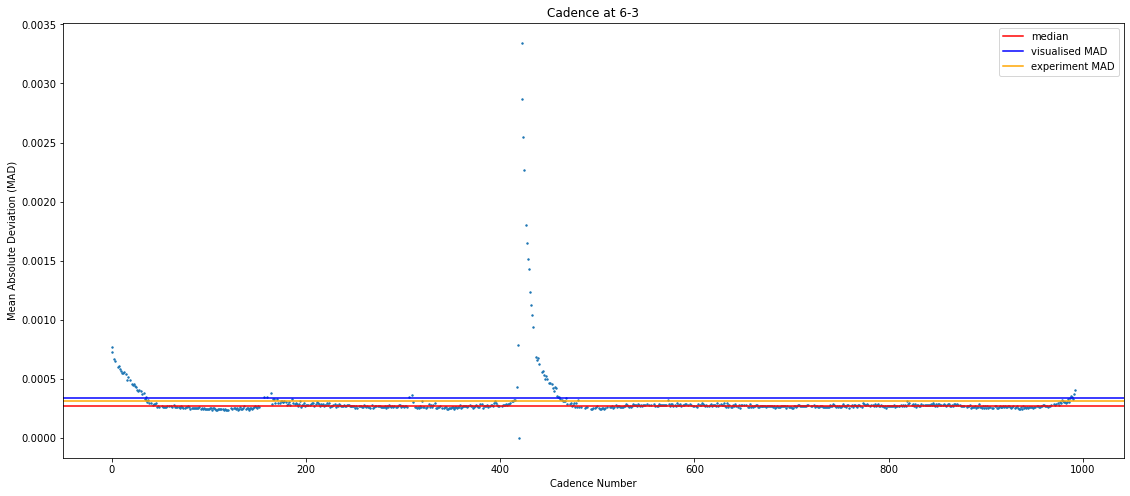

In [18]:
fig,ax = plt.subplots(figsize=(19,8))
ax.scatter(range(0,len(star_data.time[q])), mad_arr, s=2)
ax.axhline(np.nanmedian(mad_arr), c='r',label='median')
ax.axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950]),c='blue',label='visualised MAD') # 10 sigma threshold
ax.axhline(med_sig_clip + clip*rms_sig_clip, c='orange',label='experiment MAD')
ax.set_xlabel('Cadence Number')
ax.set_ylabel('Mean Absolute Deviation (MAD)')
ax.set_title(f'Cadence at {sec}-{cam}')
ax.legend()
plt.show()

In [19]:
mad_cut = mad_arr.values<(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950])) # removes any values above threshold
mad_cut2 = mad_arr.values<(med_sig_clip + clip*(rms_sig_clip))

In [36]:
matched_ind = np.where(~mad_cut2)

In [38]:
df.quality[np.array(matched_ind)[0]] = 23

In [52]:
mask = np.ones_like(star_data.time[q], dtype=bool)
for i in bad_times:
    newchunk = (star_data.time[q]<i[0])|(star_data.time[q]>i[1])
    mask = mask & newchunk

In [42]:
df = pd.DataFrame(data=[star_data.time[q],star_data.corr_flux[q],star_data.quality[q]]).T

In [43]:
cols = ['time','corr_flux','quality']
df.columns = cols

In [44]:
df.normalised_corr_flux = normalise_lc(df.corr_flux)

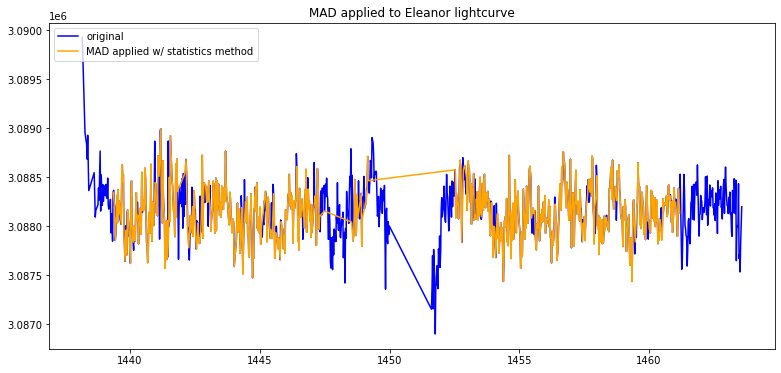

In [45]:
plt.figure(figsize=(13,6))
plt.plot(df.time[(df.quality==0)],df.corr_flux[(df.quality==0)] + 0.005,c='blue',label='original')
#plt.plot(df.time[(df.quality==0) & mask & mad_cut],df.corr_flux[(df.quality==0) & mask & mad_cut] + 0.0025,c='red',label='MAD applied w/ Daniel\'s method')
plt.plot(df.time[(df.quality==0) & mask & mad_cut2],df.corr_flux[(df.quality==0) & mask & mad_cut2],c='orange',label='MAD applied w/ statistics method')
plt.title('MAD applied to Eleanor lightcurve')
#plt.ylim([0.9985,1.0006])
plt.legend(loc='upper left') 
plt.show()

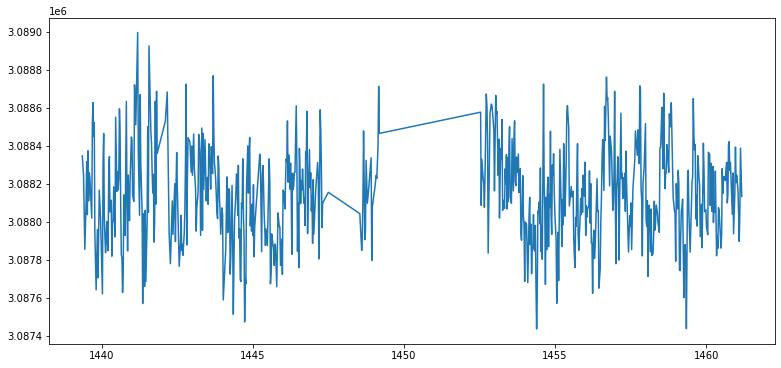

In [46]:
cut_time = df.time[(df.quality==0) & mask & mad_cut2]
cut_flux = df.corr_flux[(df.quality==0) & mask & mad_cut2]
cut_quality = df.quality[(df.quality==0) & mask & mad_cut2]

mad_cut_df = pd.concat([cut_time,cut_flux,cut_quality],axis=1)
plt.figure(figsize=(13,6))
plt.plot(mad_cut_df.time,mad_cut_df.corr_flux)

---

## Automated Search - `single_analysis_xrp.py`

In [47]:
from analysis_tools_cython import *

In [48]:
table = Table.from_pandas(mad_cut_df)

nan_rows = [ i for i in range(len(table)) if
        math.isnan(table[i][1]) or math.isnan(table[i][0]) ]

table.remove_rows(nan_rows)

spikes = [ i for i in range(1,len(table)-1) if \
        abs(table[i][1] - 0.5*(table[i-1][1]+table[i+1][1])) \
        > 3*abs(table[i+1][1] - table[i-1][1])]

for i in spikes:
    table[i][1] = 0.5*(table[i-1][1] + table[i+1][1])

Timestep of lightcurve:  30.0 minutes.
Maximum transit chance:
   Time = 1442.47 days.
   Duration = 0.52 days.
   T = -6.1
   T/sigma = -3.6
Transit depth = -8.4e-05
[8.361287719413863e-07, 8.857130692764111e-07]
Asym score: 0.944
maybeTransit


AttributeError: 'function' object has no attribute 'arrow'

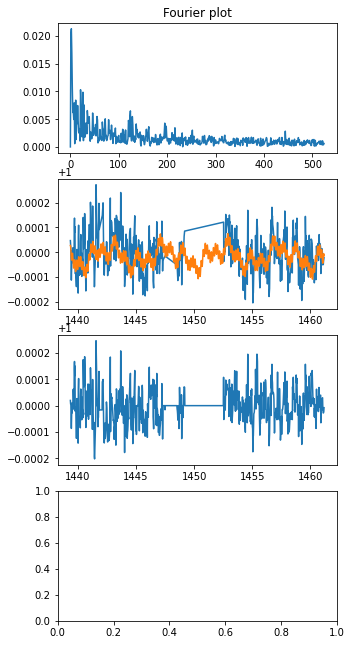

In [55]:
#to_clean = remove_zeros(table,'corr_flux')  # removing any zero points
t, flux, quality, real = clean_data(table)
timestep = calculate_timestep(table)

""""The default assumption is a 30-minute cadence."""
factor = ((1/48)/timestep)
 
N = len(t)
ones = np.ones(N)

flux = normalise_flux(flux)

# filteredflux = fourier_filter(flux, 8) # returns smooth lc
A_mag = np.abs(np.fft.rfft(flux))
# periodicnoise = flux - filteredflux


sigma = flux.std()

flux_ls = np.copy(flux)
lombscargle_filter(t, flux_ls, real, 0.05)  # happens in-place. 0.05 is minimum score
periodicnoise_ls = flux - flux_ls
flux_ls = flux_ls * real


# T1 = test_statistic_array(filteredflux, 60)
T = test_statistic_array(flux_ls, 60 * factor)
data = nonzero(T)

# Find minimum test statistic value, and its location.
m, n = np.unravel_index(T.argmin(), T.shape)
minT = T[m, n]
minT_time = t[n]
minT_duration = m * timestep
print("Timestep of lightcurve: ", round(timestep * 1440,3), "minutes.")
print("Maximum transit chance:")
print("   Time =", round(minT_time, 2), "days.")
print("   Duration =", round(minT_duration, 2), "days.")
print("   T =", round(minT, 1))
print("   T/sigma =", round(minT / data.std(), 1))

trans_start = n - math.floor((m - 1) / 2)
trans_end = trans_start + m
print("Transit depth =", round(flux[trans_start:trans_end].mean(), 6))

# Transit shape calculation
if n - 3 * m >= 0 and n + 3 * m < N:
    t2 = t[n - 3 * m : n + 3 * m]
    x2 = flux_ls[n - 3 * m : n + 3 * m]
    q2 = quality[n - 3 * m : n + 3 * m]
    background = (sum(x2[: 1 * m]) + sum(x2[5 * m :])) / (2 * m)
    x2 -= background
    paramsgauss = single_gaussian_curve_fit(t2, -x2)
    y2 = -gauss(t2, *paramsgauss)
    paramscomet = comet_curve_fit(t2, -x2)
    w2 = -comet_curve(t2, *paramscomet)

    scores = [score_fit(x2, fit) for fit in [y2, w2]]
    print(scores)
    print("Asym score:", round(scores[0] / scores[1], 4))

    #qual_flags = reduce(lambda a, b: a or b, q2)
    #print("Quality flags:", qual_flags)

# Classify events
asym, _, _ = calc_shape(m, n, t, flux)
print(classify(m, n, real, asym))

# Skip plotting if no graphical output set

# plt.xkcd()
fig1, axarr = plt.subplots(4,figsize=(5,11))
axarr[0].plot(A_mag)  # fourier plot
axarr[0].title.set_text("Fourier plot")
axarr[1].plot(t, flux + ones, t, periodicnoise_ls + ones)  #
axarr[2].plot(t, flux_ls + ones)  # lomb-scargle plot

axarr[2].title.set_text("Lomb-Scargle plot")
cax = axarr[3].imshow(T)
axarr[3].set_aspect("auto")
fig1.colorbar(cax)

# params = double_gaussian_curve_fit(T)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
# T_test_nonzero = np.array(data)
# _,bins,_ = ax2.hist(T_test_nonzero,bins=100,log=True)
# y = np.maximum(bimodal(bins,*params),10)
# ax2.plot(bins,y)
try:
    ax2.plot(t2, x2, t2, y2, t2, w2)
except:
    pass

plt.show()


---